In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# 선택 라이브러리
try:
    import xgboost as xgb
    HAS_XGB = True
except:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGB = True
except:
    HAS_LGB = False

try:
    import catboost as cb
    HAS_CB = True
except:
    HAS_CB = False


CONFIG = {
    "random_state": 42,
    "threshold": 0.5,          # 분류 임계값을 여기서 조절
    "pos_label": 1,
    "cv_splits": 5,            # (옵션) CV 쓰고 싶으면 여기서
    "use_cv": False,           # True로 바꾸면 CV 점수도 출력
}

# 모델 on/off는 여기서
ENABLED_MODELS = [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "Gradient Boosting",
    # "XGBoost",
    # "LightGBM",
    # "CatBoost",
]

# 파라미터는 여기서만 수정
MODEL_PARAMS = {
    "Logistic Regression": dict(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs",
        random_state=CONFIG["random_state"],
    ),
    "Decision Tree": dict(
        max_depth=10,
        min_samples_split=20,
        class_weight="balanced",
        random_state=CONFIG["random_state"],
    ),
    "Random Forest": dict(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        class_weight="balanced",
        n_jobs=-1,
        random_state=CONFIG["random_state"],
    ),
    "Gradient Boosting": dict(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=CONFIG["random_state"],
    ),
    "XGBoost": dict(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=CONFIG["random_state"],
        eval_metric="logloss",
    ),
    "LightGBM": dict(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",
        random_state=CONFIG["random_state"],
        verbose=-1,
    ),
    "CatBoost": dict(
        iterations=800,
        learning_rate=0.03,
        depth=6,
        random_seed=CONFIG["random_state"],
        verbose=0,
    )
}


In [2]:
train_df = pd.read_csv("../../../../data/processed/train.csv")
test_df  = pd.read_csv("../../../../data/processed/test.csv")

X_train = train_df.drop("Revenue", axis=1)
y_train = train_df["Revenue"].astype(int)

X_test = test_df.drop("Revenue", axis=1)
y_test = test_df["Revenue"].astype(int)

cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()

# 결측치 + 인코딩/스케일링까지 한 번에
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


In [3]:
def get_model(name: str):
    if name == "Logistic Regression":
        return LogisticRegression(**MODEL_PARAMS[name])
    if name == "Decision Tree":
        return DecisionTreeClassifier(**MODEL_PARAMS[name])
    if name == "Random Forest":
        return RandomForestClassifier(**MODEL_PARAMS[name])
    if name == "Gradient Boosting":
        return GradientBoostingClassifier(**MODEL_PARAMS[name])
    if name == "XGBoost" and HAS_XGB:
        return xgb.XGBClassifier(**MODEL_PARAMS[name])
    if name == "LightGBM" and HAS_LGB:
        return lgb.LGBMClassifier(**MODEL_PARAMS[name])
    if name == "CatBoost" and HAS_CB:
        return cb.CatBoostClassifier(**MODEL_PARAMS[name])
    raise ValueError(f"Unknown or unavailable model: {name}")

def predict_proba_1(model, X):
    # predict_proba 없는 모델 대비(필요 시 확장)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        z = model.decision_function(X)
        return 1 / (1 + np.exp(-z))
    raise ValueError("Model has neither predict_proba nor decision_function")

def eval_binary(y_true, proba, threshold=0.5):
    pred = (proba >= threshold).astype(int)
    return {
        "Acc": accuracy_score(y_true, pred),
        "Prec": precision_score(y_true, pred, zero_division=0),
        "Rec": recall_score(y_true, pred, zero_division=0),
        "F1": f1_score(y_true, pred, zero_division=0),
        "AUC": roc_auc_score(y_true, proba),
    }

trained = {}
rows = []

for name in ENABLED_MODELS:
    est = get_model(name)
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", est)])
    pipe.fit(X_train, y_train)

    proba_tr = predict_proba_1(pipe, X_train)
    proba_te = predict_proba_1(pipe, X_test)

    tr = eval_binary(y_train, proba_tr, threshold=CONFIG["threshold"])
    te = eval_binary(y_test,  proba_te, threshold=CONFIG["threshold"])

    rows.append({
        "Model": name,
        "Train_Acc": tr["Acc"], "Test_Acc": te["Acc"],
        "Train_Prec": tr["Prec"], "Test_Prec": te["Prec"],
        "Train_Rec": tr["Rec"], "Test_Rec": te["Rec"],
        "Train_F1": tr["F1"], "Test_F1": te["F1"],
        "Train_AUC": tr["AUC"], "Test_AUC": te["AUC"],
    })
    trained[name] = pipe

results_df = pd.DataFrame(rows).sort_values("Test_AUC", ascending=False)
results_df.style.format(precision=4)


,Model,Train_Acc,Test_Acc,Train_Prec,Test_Prec,Train_Rec,Test_Rec,Train_F1,Test_F1,Train_AUC,Test_AUC
3,Gradient Boosting,0.9268,0.8982,0.8190,0.7079,0.6763,0.5838,0.7408,0.6399,0.9574,0.9285
2,Random Forest,0.9532,0.8881,0.7845,0.6205,0.9613,0.7147,0.8640,0.6642,0.9927,0.9265
0,Logistic Regression,0.8618,0.8520,0.5374,0.5154,0.7680,0.7461,0.6323,0.6096,0.9096,0.8959
1,Decision Tree,0.8791,0.8313,0.5664,0.4731,0.9305,0.7827,0.7042,0.5897,0.9629,0.8737


In [4]:
from lazypredict.Supervised import LazyClassifier

# 전처리만 먼저 학습/변환
Xtr = preprocess.fit_transform(X_train)
Xte = preprocess.transform(X_test)

lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
lazy_models, lazy_predictions = lazy_clf.fit(Xtr, Xte, y_train, y_test)
lazy_models.head(15)


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 1526, number of negative: 8338
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 9864, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154704 -> initscore=-1.698173
[LightGBM] [Info] Start training from score -1.698173


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.90,0.77,0.77,0.89,0.43
AdaBoostClassifier,0.89,0.76,0.76,0.88,0.37
XGBClassifier,0.89,0.76,0.76,0.89,0.16
RandomForestClassifier,0.90,0.75,0.75,0.89,0.74
DecisionTreeClassifier,0.87,0.75,0.75,0.87,0.10
NearestCentroid,0.78,0.75,0.75,0.81,0.01
BaggingClassifier,0.89,0.74,0.74,0.88,0.30
BernoulliNB,0.84,0.73,0.73,0.84,0.01
Perceptron,0.82,0.73,0.73,0.83,0.02


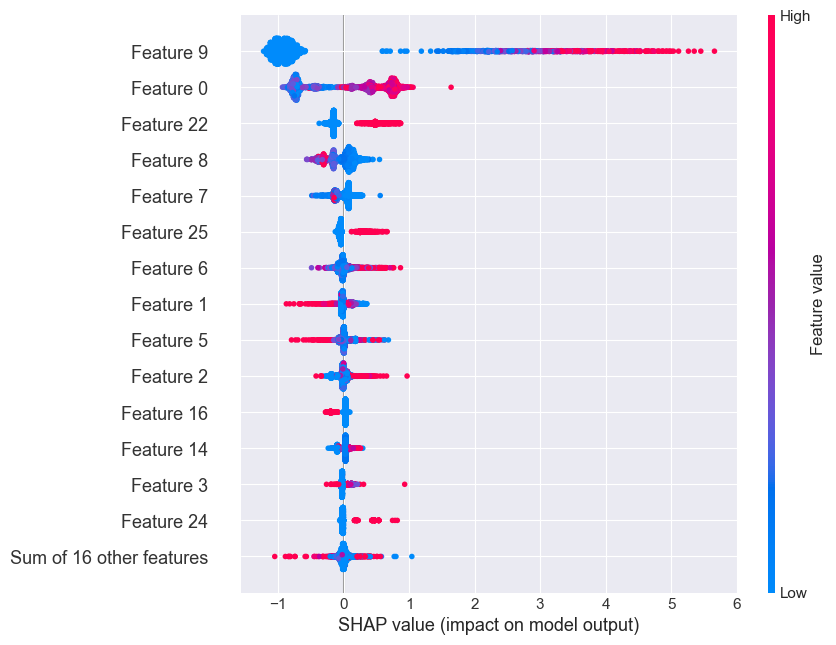

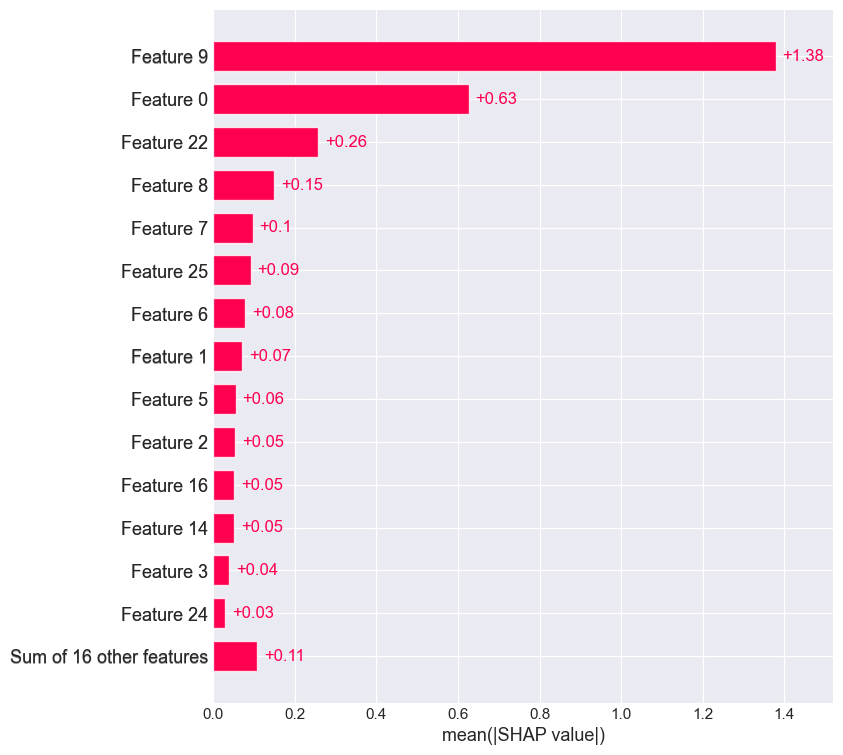

In [5]:
import shap

best_name = results_df.iloc[0]["Model"]
best_pipe = trained[best_name]

# Pipeline에서 전처리기/모델 분리
prep = best_pipe.named_steps["preprocess"]
model = best_pipe.named_steps["model"]

Xtr = prep.transform(X_train)
Xte = prep.transform(X_test)

# feature name 얻기 (OHE 포함)
feature_names = prep.get_feature_names_out()

# Tree 기반이면 TreeExplainer, 아니면 shap.Explainer로 폴백
try:
    explainer = shap.TreeExplainer(model)  # 트리 계열에 적합 [web:15]
    sv = explainer(Xte)  # shap.Explanation
except Exception:
    explainer = shap.Explainer(model, Xtr)
    sv = explainer(Xte)

# 시각화 (노트북에서 바로 표시)
shap.plots.beeswarm(sv, max_display=15)  # [web:13]
shap.plots.bar(sv, max_display=15)
